# CH 13 CNN

## The Architecture of the Visual Cortex

CNN은 인간이 이미지를 어떻게 인지하는지를 본따서 만든 알고리즘. David H. Hubel과 Torsten Wiesel의 1958,1959년 논문에 의하면 시각피질은 작은 지각 필드가 있는데, 이는 시각의 한정된 부분에만 반응한다. 그런 작은 뉴런들이 중첩해 타일처럼 하나의 이미지를 만드는 것이다. 어떤 뉴런은 수평 라인에만 반응하고, 다른 뉴런들은 다른 방향의 선에만 반응한다(두 뉴런이 같은 부분을 지각해도 다른 라인에만 반응할수 있음). 어떤 뉴런들은 더 큰 수용 영역(시각)을 가지고 더 복잡한 패턴에 반응한다.

<img src="ch13_1.png" style="width: 700px;"/>

결국 1998년 얀 라쿤 / 요슈아 벤지오 등이 LeNet-5 만들어 버림(CNN 비슷: convolutional layer / pooling layer 있음)

## Convolutional Layer

convolution
<img src="ch13_2.png" style="width:700px;" />

Convolutional layer 만드는게 중요. 모든 픽셀에 연결하지 않는다.(시각 뉴런처럼)

<img src="ch13_3.png" style="width:700px;" />

    Zero padding: 0인 패딩을 넣음.
    rows: i to (i + f_h - 1)
    cols: j to (j + f_w - 1)
    where f_h, f_w = 3

<img src="ch13_4.png" style="width:700px;" />

    -Using a Stride
$$rows: i\times s_h \to i \times s_h + f_h -1$$
$$cols: j\times s_w \to j \times s_w + j_h -1$$

<img src="ch13_5.png" style="width:700px;" />

## Filters(=convolutional kernels)

vertical filter(=sets of weights in receptive field)에 있는 검은색(weight=0)은 무시되고, 흰색 라인(weight=1)에 있는 애들만 인식된다. 이런 애들로만 구성하면 feature map이 생긴다. 훈련시킬때 CNN은 각 layer에서 가장 쓸모있는 필터를 찾아내고, 이런 필터들을 조합해 복잡한 패턴을 만든다.

<img src="ch13_6.png" style="width:1000px;" />

<img src="ch13_7.png" style="width:700px;" />

## Stacking Multiple Feature Maps

실제 convolutional layer는 여러개의 feature map으로 구성된다. 한 feature map의 모든 뉴런은 같은 파라메터(weights and bias)를 가지지만 다른 feature map은 다른 파라메터 가질수 있다. 
인풋 이미지는 여러개의 sublayer로 구성됨: 컬러 채널당 하나로. 보통 레드, 그린, 블루 세가지가 있다. 흑백은 하나의 채널만 있다. 하지만 위성사진경우에는 light frequencies를 잡기위한 추가적인 레이어가 있다.

<img src="ch13_8.png" style="width:700px;" />

$$row:i \quad col:j \quad feature\;map:k \quad convolutional\;layer: l $$
$$ layer:l-1 \quad rows: i \times s_w \to i\times s_w + f_w - 1 \quad cols: j\times s_h \to j\times s_h + f_h - 1 $$

<img src="ch13_9.png" style="width:700px;" />

## TensorFlow Implementation

$$input image = [ height, width, channles]$$
$$mini-batch = [mini-batch size, height, width, channles]$$
   $$weights = [f_h,f_w,f_n,f_n']$$
   $$bias = [f_n]$$

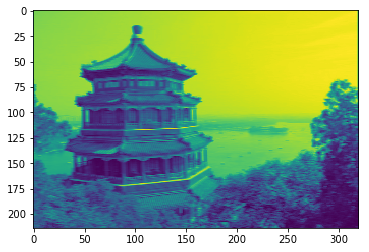

In [16]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_sample_images

# Load sample images
dataset = np.array(load_sample_images().images, dtype=np.float32)
batch_size, height, width, channels = dataset.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

# Create a graph with input X plus a convolutional layer applying the 2 filters
X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
convolution = tf.nn.conv2d(X, filters, strides=[1,2,2,1], padding="SAME")

with tf.Session() as sess:
    output = sess.run(convolution, feed_dict={X: dataset})

plt.imshow(output[0, :, :, 1]) # plot 1st image's 2nd feature map
plt.show()

In [6]:
dataset.shape

(2, 427, 640, 3)

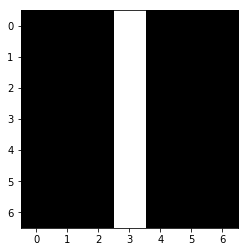

In [21]:
plt.imshow(filters[:,:,:,0])
plt.show()

    conv2d() 
    X: input mini-batch(4D tensor)
    filters: set of filters
    strides: [1,2,2,1], 맨 앞뒤는 지금 현재로는 1로, 2,2=s_h, s_w
                    (batch stride, channel stride)


<img src="ch13_10.png" style="width:600px;" />

convolutional layer는 hyperparameter들이 몇개 있다.
    # of filters, height, width, strides, padding type
    
맞는거 찾으려면 cross-validation 하자. 나중에 CNN 아키텍쳐 배울 것이다(잘 찾으려고)

## Memory Requirements

    CL은 램 너무많이 먹는다. 역전파 계산할때 중간값들 저장해줘야 되어서..
    ex) 5*5 filters, 200 feature maps of size 150*100, stide 1, RGB
    파라메터 수 = (5*5*3+1)*200 = 15,200개.
    하지만 각 feature map이 150*100 뉴론 있고 각 뉴런이 5*5*3 인풋 계산 
    -> 225M float 곱셈 해야한다.
    이는 인스턴스 하나에 필요한 것. 인스턴스 100개라면 한 레이어가 1기가 먹음
    거기다가 foward 연산->reverse pass할때 다 저장해놓고 있어야 하므로 전체 RAM 필요량은 곧 모든 레이어만큼.

## Pooling Layer

goal: `subsample`(i.e., shirnk) -메모리 /계산량 /파라메터 줄이려고. + 이미지사이즈 줄임(image shift 조금 할려고)

<img src="ch13_11.png" style="width:700px;" />

pooling layer 모든 채널에 다 하기 때문에 output depth는 input과 같음. 

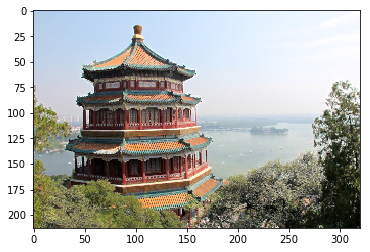

In [22]:
X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
max_pool = tf.nn.max_pool(X, ksize=[1,2,2,1], strides=[1,2,2,1],padding="VALID")

with tf.Session() as sess:
    output = sess.run(max_pool, feed_dict={X: dataset})

plt.imshow(output[0].astype(np.uint8))  # plot the output for the 1st image
plt.show()


    ksize = [batch size, height, width, channels] (kernel shape)
    (batch size = 1 왜냐면 인스턴스 한개, height/weight =1 (NO spatial dim), or channels=1

## CNN Architectures

<img src="ch13_12.png" style="width:700px;" />

<img src="ch13_13.png" style="width:700px;" />

### LeNet-5

<img src="ch13_14.png" style="width:700px;" />

<img src="ch13_15.png" style="width:700px;" />